# Imports and setup

In [4]:
! pip install numpy matplotlib
import numpy as np
import keyword
from typing import List, Dict, Tuple, Optional, Set
import functools
from dataclasses import dataclass
import traceback


# Utility functions and constants

In [5]:
_ellipsis = "…"  #unicode ellipsis for internal representation

class EinopsError(ValueError):
    """Custom error type for einops-related issues."""
    pass

def _check_axis_name(name: str) -> Tuple[bool, str]:
    """
    Validates if a string is a correct axis name for einops patterns.

    Checks for standard identifiers (no leading/trailing '_'), '1', internal '...N',
    and warns for keywords or 'axis'. Disallows invalid characters, empty strings,
    other numbers, or names starting/ending with '_'.

    Args:
        name: The potential axis name string.

    Returns:
        A tuple (is_valid, reason_string). `reason_string` is empty if valid.
    """
    if not isinstance(name, str):
        return False, "Axis name must be a string"
    if not name:
        return False, "Axis name cannot be empty"

    # Allow internal ellipsis representation (used after expansion)
    if name.startswith(_ellipsis):
        return True, ""
    # Allow anonymous axis of size 1
    if name == '1':
        return True, ""

    # Check standard Python identifier rules for user-defined names
    if str.isidentifier(name):
        if name.startswith("_") or name.endswith("_"):
            return False, "User axis name should not start or end with underscore"
        if keyword.iskeyword(name):
            warnings.warn(f"Using keyword '{name}' as axis name is discouraged", RuntimeWarning)
        if name == "axis":
            warnings.warn("Using 'axis' as an axis name is discouraged", FutureWarning)
        return True, ""

    # Disallow other numeric names
    if name.isdecimal():
        return False, f"Numerical axis '{name}' not allowed (only '1')"

    # If none of the above, it's invalid
    return False, f"'{name}' is not a valid identifier or allowed pattern component"


# Parsing

In [6]:
class ParsedExpression:
    """
    Parses one side of an einops expression (e.g., "b c (h w)").

    Extracts axis names, detects ellipsis, and determines the compositional
    structure (grouping by spaces and parentheses).

    Attributes:
        expression: The original expression string.
        has_ellipsis: True if '...' was present.
        identifiers: Set of unique user-defined axis identifiers (excluding '1',
                     includes internal `_ellipsis` marker if present).
        composition: List of lists representing structure. '1' becomes [],
                     parentheses form inner lists. Example:
                     "a (b c) 1 d" -> [['a'], ['b', 'c'], [], ['d']]
    """
    def __init__(self, expression: str):
        """
        Initializes and parses the expression string.

        Args:
            expression: The string pattern component.

        Raises:
            EinopsError: For syntax errors (invalid chars, parentheses issues, etc.).
        """
        self.expression: str = expression
        self.has_ellipsis: bool = False
        self.identifiers: Set[str] = set()
        self.composition: List[List[str]] = [] # e.g., [['a'], ['b', 'c'], []] for "a (b c) 1"

        if "." in expression:
            if "..." not in expression or expression.count("...") != 1 or expression.count(".") != 3:
                raise EinopsError("Expression may contain dots only inside ellipsis (...)")
            expression = expression.replace("...", _ellipsis)
            self.has_ellipsis = True

        current_identifier: Optional[str] = None
        in_brackets: bool = False
        current_bracket_group: Optional[List[str]] = None

        for char in expression:
            if char == '(':
                if current_identifier is not None:
                    self._add_composition_element(current_identifier, in_brackets, current_bracket_group)
                current_identifier = None

                if in_brackets:
                    raise EinopsError("Nested parentheses are not allowed")
                in_brackets = True
                current_bracket_group = []

            elif char == ')':
                if current_identifier is not None:
                    self._add_composition_element(current_identifier, in_brackets, current_bracket_group)
                current_identifier = None

                if not in_brackets or current_bracket_group is None:
                    raise EinopsError("Mismatched parentheses: encountered ')' without matching '('")
                if not current_bracket_group:
                    raise EinopsError("Empty parentheses () are not allowed")
                if len(current_bracket_group) != len(set(current_bracket_group)):
                    duplicates = {x for x in current_bracket_group if current_bracket_group.count(x) > 1}
                    raise EinopsError(f"Duplicate identifiers within parentheses: {duplicates}")

                self.composition.append(current_bracket_group)
                in_brackets = False
                current_bracket_group = None

            elif char.isspace():
                if current_identifier is not None:
                    self._add_composition_element(current_identifier, in_brackets, current_bracket_group)
                current_identifier = None

            elif char.isalnum() or char == '_' or char == _ellipsis:
                current_identifier = (current_identifier or "") + char
            else:
                raise EinopsError(f"Invalid character '{char}' in expression '{self.expression}'")

        if current_identifier is not None:
            self._add_composition_element(current_identifier, in_brackets, current_bracket_group)

        if in_brackets:
            raise EinopsError("Mismatched parentheses: unclosed '('")

    def _add_composition_element(self, identifier: str, in_brackets: bool,
                                 bracket_group: Optional[List[str]]):
        """
        Internal helper to validate and add a parsed identifier to the composition.
        Handles '1', validation, and adding to the correct list (main or bracket group).
        """
        if identifier == '1':
            if in_brackets:
                raise EinopsError("Anonymous dimension '1' is not allowed inside parentheses")
            self.composition.append([]) # Represent '1' as an empty list
            return

        is_valid, reason = _check_axis_name(identifier)
        if not is_valid:
            raise EinopsError(f"Invalid axis identifier '{identifier}': {reason}")

        if identifier != _ellipsis:
            self.identifiers.add(identifier)
        elif self.has_ellipsis:
             self.identifiers.add(_ellipsis) # Track marker only if ellipsis was originally present

        if in_brackets:
            if bracket_group is None:
                # Should not happen if parsing logic is correct
                raise RuntimeError("Internal parsing error: bracket_group is None while in_brackets is True")
            bracket_group.append(identifier)
        else:
            self.composition.append([identifier]) # Add as a new standalone group


def _expand_composition(composition: List[List[str]],
                        ellipsis_names: List[str],
                        ellipsis_marker: str) -> List[List[str]]:
    """
    Replaces the internal ellipsis marker (`_ellipsis`) in a composition
    with the actual list of generated ellipsis axis names (e.g., ['...0', '...1']).

    Example: [['b'], [_ellipsis], ['c']] with ['...0', '...1'] -> [['b'], ['...0'], ['...1'], ['c']]
             [['b', _ellipsis, 'c']] with ['...0', '...1'] -> [['b', '...0', '...1', 'c']]
    """
    expanded_composition = []
    for group in composition:
        if group == [ellipsis_marker]:
            # Replace marker group with list of singleton groups for each ellipsis name
            expanded_composition.extend([[name] for name in ellipsis_names])
        else:
            # Expand ellipsis marker within a composite group
            new_group = []
            contains_ellipsis = False
            for axis in group:
                if axis == ellipsis_marker:
                    new_group.extend(ellipsis_names)
                    contains_ellipsis = True
                else:
                    new_group.append(axis)
            # Add the modified group (or original if no ellipsis was present)
            if new_group or not contains_ellipsis: # Avoid adding empty list if original was just `[...]`
                expanded_composition.append(new_group)
    return expanded_composition


# Preparing the recipe

In [7]:
@dataclass(frozen=True)
class RearrangeRecipe:
    """
    Immutable plan for a rearrange operation, derived from pattern and input info.

    Stores parsed/analyzed structure, axis mappings, and transformation steps
    (reshapes, transpose, squeeze, expand_dims, broadcast) needed. Caching this
    avoids redundant analysis for repeated calls with the same signature.

    Attributes:
        elementary_left_axes: Tuple of all axis names on left after splits/ellipsis.
            Represents shape after initial reshape. ('b', 'h', 'w', '_anon1_0', 'c')
        axis_name_to_pos: Maps elementary left axis name to its index.
            {'b': 0, 'h': 1, 'w': 2, '_anon1_0': 3, 'c': 4}
        input_composition: Structure of input axes before splitting, using elementary names.
            (('b',), ('h', 'w'), ('_anon1_0',), ('c',))
        needs_initial_reshape: True if left side has composites '()' or '1'.
        dropped_anon1_indices: Original indices of left '1' axes dropped on right.
        axes_permutation: Transpose order for remaining axes (after drops) for right side.
        inserted_1_indices: Indices where new '1' dims are inserted (post-transpose).
        final_elementary_info: Tuple detailing each axis after permutation/insertion.
            `(name: str, known_size: Optional[int], source_pos_if_repeat: Optional[int])`
            `known_size` is 1 for new '1's. `source_pos_if_repeat` links new axes
            to their size-1 source axis on the left for broadcasting.
        right_composition: Compositional structure of output axes using final elem names.
            Used for final merge reshape. (('b', 'h'), ('w',), ('c',))
        final_shape_group_count: Number of dimension groups (rank) in the final output.
    """
    elementary_left_axes: Tuple[str, ...]
    axis_name_to_pos: Dict[str, int]
    input_composition: Tuple[Tuple[str, ...], ...]
    needs_initial_reshape: bool
    dropped_anon1_indices: Tuple[int, ...]
    axes_permutation: Tuple[int, ...]
    inserted_1_indices: Tuple[int, ...]
    final_elementary_info: Tuple[Tuple[str, Optional[int], Optional[int]], ...]
    right_composition: Tuple[Tuple[str, ...], ...]
    final_shape_group_count: int

    @classmethod
    def freeze_composition(cls, composition: List[List[str]]) -> Tuple[Tuple[str, ...], ...]:
         return tuple(tuple(group) for group in composition)
    @classmethod
    def freeze_elementary_axes(cls, axes: List[str]) -> Tuple[str, ...]:
         return tuple(axes)
    @classmethod
    def freeze_elementary_info(cls, info: List[Tuple[str, Optional[int], Optional[int]]]) -> Tuple[Tuple[str, Optional[int], Optional[int]], ...]:
         return tuple(info)


## Cached recipe preparation
This enables efficient reuse of the rearrangement plan for identical patterns and input sizes. We cache the parsed pattern and the input dimensions to avoid redundant analysis.

In [8]:
@functools.lru_cache(maxsize=1024)
def _prepare_rearrange_recipe(pattern: str, ndim: int, axes_lengths_keys: Tuple[str, ...]) -> RearrangeRecipe:
    """
    Analyzes pattern, input dims, and known axis names to create a RearrangeRecipe.

    Parses pattern, handles ellipsis, plans reshapes, permutations, dropping/inserting '1's,
    and maps sources for broadcasting/repetition. Caches the resulting recipe based on
    pattern, ndim, and the sorted keys of `axes_lengths`.

    Args:
        pattern: The einops rearrange pattern string (e.g., 'b h w c -> b c h w').
        ndim: The number of dimensions of the input tensor.
        axes_lengths_keys: Sorted tuple of keys provided in `**axes_lengths`.

    Returns:
        A RearrangeRecipe containing the precomputed plan.

    Raises:
        EinopsError: For parsing errors, pattern/ndim inconsistencies, missing sizes, etc.
    """
    if not isinstance(pattern, str): raise EinopsError("Pattern must be a string.")
    if not pattern.strip(): raise EinopsError("Pattern cannot be empty.")
    if "->" not in pattern or pattern.count("->") != 1: raise EinopsError("Pattern must contain exactly one '->' separator.")

    left_str, right_str = map(str.strip, pattern.split("->"))
    try:
        left_expr = ParsedExpression(left_str)
        right_expr = ParsedExpression(right_str)
    except EinopsError as e:
        raise EinopsError(f"Error parsing pattern '{pattern}': {e}") from e

    if left_expr.has_ellipsis != right_expr.has_ellipsis:
        raise EinopsError("Ellipsis (...) must appear on both sides of '->' or neither.")

    # Validate scalar input patterns early
    if ndim == 0 and left_expr.composition and left_expr.composition != [[_ellipsis]]:
        raise EinopsError("Left side pattern must be empty or '...' for scalar (0D) input.")
    if not left_expr.composition and ndim > 0 and right_expr.expression and right_expr.expression != _ellipsis:
        raise EinopsError("Left side pattern cannot be empty for non-scalar input unless right is empty or ellipsis.")

    left_composition = left_expr.composition
    right_composition = right_expr.composition

    # Expand ellipsis if present
    ellipsis_names: List[str] = []
    if left_expr.has_ellipsis:
        num_non_ellipsis_input_dims = sum(1 for group in left_composition if group != [_ellipsis])
        if ndim < num_non_ellipsis_input_dims:
            raise EinopsError(f"Input tensor has {ndim} dims, pattern requires >= {num_non_ellipsis_input_dims} "
                              f"non-ellipsis dims for left ('{left_str}')")
        ellipsis_ndim = ndim - num_non_ellipsis_input_dims
        ellipsis_names = [f"{_ellipsis}{i}" for i in range(ellipsis_ndim)]
        left_composition = _expand_composition(left_composition, ellipsis_names, _ellipsis)
        right_composition = _expand_composition(right_composition, ellipsis_names, _ellipsis)
        right_expr.identifiers.update(ellipsis_names) # Ensure ellipsis names are known on right

    # Analyze left side: determine elementary axes and input structure
    elementary_left_axes: List[str] = []
    axis_name_to_pos: Dict[str, int] = {}
    input_composition_for_recipe: List[List[str]] = []
    processed_left_identifiers: Set[str] = set()
    potential_anon1_source_indices: Set[int] = set() # Original indices of input '1' dims

    current_elementary_pos = 0
    current_dim_index = 0

    for group in left_composition:
        group_axes_names: List[str] = []
        if not group: # Anonymous '1' dimension
            axis_name = f"_anon1_{current_dim_index}"
            elementary_left_axes.append(axis_name)
            axis_name_to_pos[axis_name] = current_elementary_pos
            group_axes_names.append(axis_name)
            processed_left_identifiers.add(axis_name)
            potential_anon1_source_indices.add(current_elementary_pos)
            current_elementary_pos += 1
        else: # Named axis or composite group
            for axis_name in group:
                if axis_name in processed_left_identifiers:
                    raise EinopsError(f"Duplicate identifier '{axis_name}' on left side ('{left_str}')")
                # Basic name validation already done by ParsedExpression
                processed_left_identifiers.add(axis_name)
                elementary_left_axes.append(axis_name)
                axis_name_to_pos[axis_name] = current_elementary_pos
                group_axes_names.append(axis_name)
                current_elementary_pos += 1

        input_composition_for_recipe.append(group_axes_names)
        current_dim_index += 1

    if ndim > 0 and left_str and current_dim_index != ndim:
        raise EinopsError(f"Pattern left side '{left_str}' implies {current_dim_index} dimensions, "
                          f"but input tensor has {ndim}.")

    needs_initial_reshape = (ndim > 0 and len(elementary_left_axes) != ndim)
    all_input_indices = set(range(len(elementary_left_axes)))

    # Analyze right side (Pass 1): Identify kept, new, dropped axes. Validate new axis sizes.
    processed_right_identifiers_pass1: Set[str] = set()
    final_shape_group_count: int = len(right_composition)
    new_axes_requiring_size: List[str] = [] # User axes appearing only on right
    kept_axes_indices_from_left: Set[int] = set() # Original indices kept on right
    axis_names_from_kwargs_keys = set(axes_lengths_keys)

    for group in right_composition:
        if not group: continue # Skip anonymous '1' on right for now
        for axis_name in group:
            if axis_name in processed_right_identifiers_pass1 and not axis_name.startswith(_ellipsis):
                raise EinopsError(f"Duplicate identifier '{axis_name}' on right side ('{right_str}')")
            # Basic name validation done by ParsedExpression
            processed_right_identifiers_pass1.add(axis_name)

            if axis_name in axis_name_to_pos:
                kept_axes_indices_from_left.add(axis_name_to_pos[axis_name])
            elif not axis_name.startswith(_ellipsis): # New user-defined axis
                new_axes_requiring_size.append(axis_name)
                if axis_name not in axis_names_from_kwargs_keys:
                     raise EinopsError(f"New axis '{axis_name}' on right side ('{right_str}') "
                                       f"requires size specification in **axes_lengths.")

    # Determine sources for new axes (repetition/broadcasting from size-1 axes on left)
    available_potential_sources = potential_anon1_source_indices.copy()
    source_map_for_new_axes: Dict[str, int] = {} # new_axis_name -> original_source_index
    consumed_sources_indices: Set[int] = set()

    for new_axis_name in new_axes_requiring_size:
        if not available_potential_sources:
            raise EinopsError(f"Operation (creation of axis '{new_axis_name}') requires an input axis of size 1 "
                              f"for repetition/broadcasting, but none were provided or available on the left side.")
        source_index = available_potential_sources.pop()
        source_map_for_new_axes[new_axis_name] = source_index
        consumed_sources_indices.add(source_index)

    # Determine dropped axes (must be anonymous '1's or consumed sources)
    dropped_indices: Set[int] = set()
    dropped_anon1_indices_list: List[int] = []
    non_droppable_unused: List[str] = []

    for i, name in enumerate(elementary_left_axes):
        is_kept_directly = i in kept_axes_indices_from_left
        is_consumed_as_source = i in consumed_sources_indices

        if not is_kept_directly and not is_consumed_as_source:
            dropped_indices.add(i)
            if name.startswith("_anon1_"):
                dropped_anon1_indices_list.append(i)
            elif not name.startswith(_ellipsis): # Ellipsis axes can be implicitly dropped if dims match
                non_droppable_unused.append(name)

    if non_droppable_unused:
        raise EinopsError(f"Input axes {non_droppable_unused} were specified on the left "
                          f"but are not used on the right side ('{right_str}'). "
                          f"Only anonymous '1' axes or axes used as sources for repetition can be dropped.")

    # Build mapping from original kept indices to post-squeeze indices
    kept_input_indices = sorted(list(all_input_indices - dropped_indices))
    old_kept_index_to_new_index: Dict[int, int] = {
        old_idx: new_idx for new_idx, old_idx in enumerate(kept_input_indices)
    }

    # Analyze right side (Pass 2): Build permutation, final info, insertion list
    axes_permutation_list: List[int] = [] # Permutation indices for post-squeeze tensor
    final_elementary_info_list: List[Tuple[str, Optional[int], Optional[int]]] = []
    inserted_1_indices_list: List[int] = [] # Indices for np.expand_dims (post-transpose)
    current_intermediate_output_dim = 0 # Tracks dim index after transpose

    for group in right_composition:
        if not group:  # Insertion '1' on the right side
            inserted_1_indices_list.append(current_intermediate_output_dim)
            current_intermediate_output_dim += 1 # This insertion increases dimensionality
        else:  # Named or composite group on the right side
            num_elementary_axes_in_group = 0
            for axis_name in group:
                num_elementary_axes_in_group += 1
                source_pos: Optional[int] = None
                new_index_post_squeeze: Optional[int] = None

                if axis_name in axis_name_to_pos:  # Axis comes directly from the left
                    source_pos = axis_name_to_pos[axis_name]
                    if source_pos not in old_kept_index_to_new_index: # Should be kept
                        raise EinopsError(f"Internal Error: Kept axis '{axis_name}' (pos {source_pos}) not found in post-squeeze mapping.")
                    new_index_post_squeeze = old_kept_index_to_new_index[source_pos]
                    axes_permutation_list.append(new_index_post_squeeze)
                    size = 1 if axis_name.startswith("_anon1_") else None
                    final_elementary_info_list.append((axis_name, size, None))

                elif axis_name in source_map_for_new_axes: # New axis created via repetition
                    source_pos = source_map_for_new_axes[axis_name]
                    if source_pos not in old_kept_index_to_new_index: # Source must be kept
                         source_axis_name = elementary_left_axes[source_pos]
                         raise EinopsError(f"Internal Error: Repetition source axis '{source_axis_name}' (pos {source_pos}) not found in post-squeeze mapping.")
                    new_index_post_squeeze = old_kept_index_to_new_index[source_pos]
                    axes_permutation_list.append(new_index_post_squeeze)
                    final_elementary_info_list.append((axis_name, None, source_pos)) # Store source pos

                elif axis_name.startswith(_ellipsis): # Ellipsis axis
                    source_pos = axis_name_to_pos.get(axis_name)
                    if source_pos is None: raise EinopsError(f"Internal Error: Ellipsis axis '{axis_name}' not found.")
                    if source_pos not in old_kept_index_to_new_index: raise EinopsError(f"Internal Error: Ellipsis axis '{axis_name}' (pos {source_pos}) not found in post-squeeze map.")
                    new_index_post_squeeze = old_kept_index_to_new_index[source_pos]
                    axes_permutation_list.append(new_index_post_squeeze)
                    final_elementary_info_list.append((axis_name, None, None))

                else: # Should not be reachable
                    raise EinopsError(f"Internal Error: Unhandled axis '{axis_name}' during recipe building pass 2.")

            # Advance intermediate dim counter by number of elementary axes processed in this group
            current_intermediate_output_dim += num_elementary_axes_in_group


    # Final validation: Identifier consistency between left and right (user-defined axes)
    user_left_identifiers = {ax for ax in axis_name_to_pos if not ax.startswith(('_', _ellipsis))}
    user_right_identifiers = {name for group in right_composition if group for name in group if not name.startswith(('_', _ellipsis))}
    user_axes_introduced_on_right = {name for name in new_axes_requiring_size if not name.startswith(('_', _ellipsis))}
    user_axes_from_left_on_right = user_right_identifiers - user_axes_introduced_on_right

    truly_missing_on_right = set()
    for ax_name in user_left_identifiers:
        ax_pos = axis_name_to_pos[ax_name]
        if ax_pos not in dropped_indices and ax_name not in user_axes_from_left_on_right:
            truly_missing_on_right.add(ax_name)
    diff_right_only = user_axes_from_left_on_right - user_left_identifiers # Should be empty

    if truly_missing_on_right or diff_right_only:
        message = "Axis name consistency error (checked user-defined names only):"
        if truly_missing_on_right: message += f"\n  Left axes missing on right (and not dropped '1's): {truly_missing_on_right}"
        if diff_right_only: message += f"\n  Right axes not found on left (and not new): {diff_right_only}" # Internal error
        raise EinopsError(message)

    # Freeze recipe components into immutable structures
    frozen_left_axes = RearrangeRecipe.freeze_elementary_axes(elementary_left_axes)
    frozen_input_comp = RearrangeRecipe.freeze_composition(input_composition_for_recipe)
    frozen_right_comp = RearrangeRecipe.freeze_composition(right_composition)
    frozen_perm = tuple(axes_permutation_list)
    frozen_final_info = RearrangeRecipe.freeze_elementary_info(final_elementary_info_list)
    frozen_inserted_1_indices = tuple(sorted(inserted_1_indices_list))
    frozen_dropped_anon1_indices = tuple(sorted(dropped_anon1_indices_list)) # Sort for deterministic squeeze

    return RearrangeRecipe(
        elementary_left_axes=frozen_left_axes,
        axis_name_to_pos=axis_name_to_pos,
        input_composition=frozen_input_comp,
        needs_initial_reshape=needs_initial_reshape,
        dropped_anon1_indices=frozen_dropped_anon1_indices,
        axes_permutation=frozen_perm,
        inserted_1_indices=frozen_inserted_1_indices,
        final_elementary_info=frozen_final_info,
        right_composition=frozen_right_comp,
        final_shape_group_count=final_shape_group_count,
    )

# Rearranging the tensor

In [9]:
def rearrange(tensor: np.ndarray, pattern: str, **axes_lengths: int) -> np.ndarray:
    """
    Rearranges dimensions of a NumPy array according to the einops pattern.

    Supports transpose, reshape (split/merge), add/remove dimension, ellipsis,
    and repetition/broadcasting via a flexible pattern string.

    Examples:
        `rearrange(x, 'b h w c -> b c h w')` # Transpose
        `rearrange(x, 'b (h w) c -> b h w c', h=10)` # Split
        `rearrange(x, 'b h w c -> b (h w) c')` # Merge
        `rearrange(x, 'b h w -> b h w 1')` # Add dimension
        `rearrange(x, 'b h w 1 -> b h w')` # Remove dimension
        `rearrange(x, '... c -> c ...')` # Ellipsis
        `rearrange(x, 'h w -> h w c', c=3)` # Repetition (if x has size 1)

    Args:
        tensor: Input NumPy array.
        pattern: Einops pattern string (e.g., 'b h w c -> b (h w) c').
        **axes_lengths: Sizes for newly created or unknown dimensions (e.g., `h=10`).

    Returns:
        The rearranged NumPy array.

    Raises:
        EinopsError: For invalid pattern, shape inconsistencies, missing axis lengths, etc.
        ValueError: For underlying NumPy operation failures (e.g., reshape size mismatch).
        TypeError: For incorrect input types.
    """
    try:
        if not isinstance(tensor, np.ndarray):
            raise EinopsError("Input tensor must be a NumPy array.")

        ndim = tensor.ndim
        # Use sorted keys for cache consistency
        axes_lengths_keys = tuple(sorted(axes_lengths.keys()))

        # Get the precomputed plan (cached)
        recipe = _prepare_rearrange_recipe(pattern, ndim, axes_lengths_keys)

        # Handle scalar input (ndim == 0)
        if ndim == 0:
            if not recipe.right_composition: # e.g., ' -> ' or '... -> ...'
                return tensor.reshape(()) if tensor.shape != () else tensor # Ensure scalar output shape
            is_only_ones = all(not group for group in recipe.right_composition) # e.g., ' -> 1 1'
            if is_only_ones:
                target_shape = (1,) * recipe.final_shape_group_count
                try: return tensor.reshape(target_shape)
                except (ValueError, TypeError) as e: raise EinopsError(f"Failed reshape scalar to {target_shape}: {e}") from e
            else: # Other patterns invalid for scalar input (caught by recipe prep)
                right_str = pattern.split('->')[1].strip()
                raise EinopsError(f"Invalid pattern right side ('{right_str}') for scalar (0D) input.")

        # Determine concrete sizes for all elementary axes using tensor shape & axes_lengths
        axis_name_to_size: Dict[str, int] = {}
        tensor_shape = tensor.shape

        # Pass 1: Populate sizes from axes_lengths and pattern-inferred sizes ('1's)
        processed_names_in_kwargs = set()
        for name, recipe_size, src_pos in recipe.final_elementary_info:
            if name in axes_lengths:
                size = axes_lengths[name]
                if not isinstance(size, int) or size <= 0: raise EinopsError(f"Axis length '{name}' must be positive int, got {size}")
                if recipe_size is not None and recipe_size != size: raise EinopsError(f"Axis '{name}' fixed size {recipe_size} from pattern conflicts with provided size {size}.")
                axis_name_to_size[name] = size
                processed_names_in_kwargs.add(name)
            elif recipe_size is not None: # Size known from pattern (must be 1)
                axis_name_to_size[name] = recipe_size

        # Pass 2: Add sizes for axes only present in axes_lengths (new axes)
        for name, size in axes_lengths.items():
            if name not in axis_name_to_size and name not in processed_names_in_kwargs:
                 if not isinstance(size, int) or size <= 0: raise EinopsError(f"Axis length '{name}' must be positive int, got {size}")
                 is_new_axis = any(info[0] == name and info[2] is not None for info in recipe.final_elementary_info)
                 is_present_on_left = name in recipe.axis_name_to_pos
                 if not is_new_axis and not is_present_on_left: warnings.warn(f"Provided size for axis '{name}' which does not appear in the pattern.", RuntimeWarning)
                 axis_name_to_size[name] = size

        # Pass 3: Infer remaining sizes from tensor_shape and input_composition
        current_dim_index = 0
        for group_index, group in enumerate(recipe.input_composition):
            if current_dim_index >= ndim: raise EinopsError(f"Internal Error: Pattern implies more input dimensions ({group_index+1}) than tensor provides ({ndim}).")

            current_dim_size = tensor_shape[current_dim_index]
            known_size_product = 1
            unknown_axes_in_group: List[str] = []

            for axis_name in group:
                if axis_name in axis_name_to_size: known_size_product *= axis_name_to_size[axis_name]
                else: unknown_axes_in_group.append(axis_name)

            if known_size_product == 0: raise EinopsError(f"Shape error: Product of known dimensions in group '({' '.join(group) if group else '1'})' is zero.")

            if not unknown_axes_in_group: # All sizes known, validate product
                if known_size_product != current_dim_size:
                    raise EinopsError(f"Shape mismatch for input dim {current_dim_index}: "
                                      f"Pattern group '({' '.join(group) if group else '1'})' size {known_size_product} != tensor dim size {current_dim_size}.")
            elif len(unknown_axes_in_group) == 1: # Infer the single unknown size
                unknown_axis_name = unknown_axes_in_group[0]
                if known_size_product <= 0: raise EinopsError(f"Internal Error: Cannot divide by non-positive known size product {known_size_product}.")
                inferred_size, remainder = divmod(current_dim_size, known_size_product)
                if remainder != 0 or inferred_size < 0 or (inferred_size == 0 and current_dim_size != 0):
                    raise EinopsError(f"Shape mismatch for input dim {current_dim_index}: Tensor size {current_dim_size} "
                                      f"not divisible by known sizes ({known_size_product}) in group '({' '.join(group) if group else '1'})' "
                                      f"to determine size of '{unknown_axis_name}'.")
                axis_name_to_size[unknown_axis_name] = inferred_size
            else: # Multiple unknowns, ambiguous
                raise EinopsError(f"Cannot infer sizes for multiple axes {unknown_axes_in_group} "
                                  f"in input group {group_index} from dimension {current_dim_index} (size {current_dim_size}). "
                                  f"Provide sizes for at least {len(unknown_axes_in_group) - 1} of them.")
            current_dim_index += 1

        # Execute NumPy operations based on the recipe
        current_tensor = tensor

        # Initial Reshape (Split composite axes '()', handle '1')
        if recipe.needs_initial_reshape:
            try:
                shape_after_split = tuple(axis_name_to_size[ax] for ax in recipe.elementary_left_axes)
                current_tensor = tensor.reshape(shape_after_split)
            except (ValueError, KeyError, TypeError) as e:
                shape_str = ','.join(str(axis_name_to_size.get(ax, '?')) for ax in recipe.elementary_left_axes)
                raise EinopsError(f"Failed initial reshape from {tensor.shape} to ({shape_str}). Error: {e}") from e

        # Drop Anon '1' dimensions via squeeze
        if recipe.dropped_anon1_indices:
            # Validate that dimensions to be dropped are indeed size 1
            for idx in recipe.dropped_anon1_indices:
                if idx >= current_tensor.ndim or current_tensor.shape[idx] != 1:
                     el_name = recipe.elementary_left_axes[idx] if idx < len(recipe.elementary_left_axes) else '?'
                     raise EinopsError(f"Pattern attempts to drop axis {idx} ('{el_name}') which is not size 1. "
                                       f"Current shape: {current_tensor.shape}")
            try:
                current_tensor = np.squeeze(current_tensor, axis=recipe.dropped_anon1_indices)
            except ValueError as e:
                 raise EinopsError(f"Failed squeezing axes {recipe.dropped_anon1_indices}. Shape: {current_tensor.shape}. Error: {e}") from e

        # Transposition (Reorder remaining axes)
        if recipe.axes_permutation:
            try:
                # Validate permutation against the current tensor dimensions (post-squeeze)
                if len(recipe.axes_permutation) != current_tensor.ndim:
                     raise EinopsError(f"Internal Error: Permutation length {len(recipe.axes_permutation)} != tensor ndim {current_tensor.ndim}. Perm: {recipe.axes_permutation}, Shape: {current_tensor.shape}")
                if any(p < 0 or p >= current_tensor.ndim for p in recipe.axes_permutation):
                     raise EinopsError(f"Internal Error: Invalid index in permutation {recipe.axes_permutation} for shape {current_tensor.shape}")

                current_tensor = current_tensor.transpose(recipe.axes_permutation)
            except (ValueError, IndexError) as e:
                raise EinopsError(f"Failed transpose. Shape (post-squeeze): {current_tensor.shape}, Perm: {recipe.axes_permutation}. Error: {e}") from e

        # Insert new '1' dimensions via expand_dims
        if recipe.inserted_1_indices:
            # Process in ascending order (recipe ensures this)
            for index in recipe.inserted_1_indices:
                try:
                    if index < 0 or index > current_tensor.ndim: # Allows insertion at the end
                         raise EinopsError(f"Internal Error: Invalid insertion index {index} for shape {current_tensor.shape}")
                    current_tensor = np.expand_dims(current_tensor, axis=index)
                except np.AxisError as e:
                     raise EinopsError(f"Failed inserting dim at index {index}. Shape (post-transpose): {current_tensor.shape}. Error: {e}") from e

        # Repetition (Broadcasting for *new* axes from size-1 sources)
        repetition_needed = any(src_pos is not None for _, _, src_pos in recipe.final_elementary_info)
        if repetition_needed:
            try:
                final_broadcast_target_shape_list = list(current_tensor.shape) # Start with current shape (post-insert)

                # --- Mappings needed to find the source axis's current position ---
                # 1. Map original left indices -> position after squeeze
                all_input_indices_set = set(range(len(recipe.elementary_left_axes)))
                kept_input_indices_broadcast = sorted(list(all_input_indices_set - set(recipe.dropped_anon1_indices)))
                old_kept_idx_to_new_squeezed_idx: Dict[int, int] = {
                    old_idx: new_idx for new_idx, old_idx in enumerate(kept_input_indices_broadcast)
                }
                # 2. Map post-squeeze indices -> position after transpose
                perm_map_broadcast: Dict[int, int] = {
                    old_post_squeeze_idx: new_post_transpose_idx
                    for new_post_transpose_idx, old_post_squeeze_idx in enumerate(recipe.axes_permutation)
                } if recipe.axes_permutation else {i: i for i in range(current_tensor.ndim)}

                # --- Determine target shape for broadcasting ---
                for final_info_index, (axis_name, _, src_pos) in enumerate(recipe.final_elementary_info):
                     if src_pos is not None: # This axis needs broadcasting from source 'src_pos'
                          target_size = axis_name_to_size[axis_name]

                          # Find current position of the source axis
                          if src_pos not in old_kept_idx_to_new_squeezed_idx: raise EinopsError(f"Internal Error: Broadcast source index {src_pos} was dropped.")
                          index_post_squeeze = old_kept_idx_to_new_squeezed_idx[src_pos]
                          if index_post_squeeze not in perm_map_broadcast: raise EinopsError(f"Internal Logic Error: Broadcast source axis (post-squeeze index {index_post_squeeze}) not in permutation map.")
                          index_post_transpose = perm_map_broadcast[index_post_squeeze]
                          insertions_before = sum(1 for ins_idx in recipe.inserted_1_indices if ins_idx <= index_post_transpose)
                          final_pos_in_current_tensor = index_post_transpose + insertions_before

                          # Validate index and source size (must be 1 unless target size is also 1)
                          if not (0 <= final_pos_in_current_tensor < len(final_broadcast_target_shape_list)):
                               raise IndexError(f"Internal Error: Calculated broadcast pos {final_pos_in_current_tensor} out of bounds for shape {final_broadcast_target_shape_list}")
                          current_size_at_pos = final_broadcast_target_shape_list[final_pos_in_current_tensor]
                          if current_size_at_pos != 1 and target_size != current_size_at_pos:
                              source_axis_name = recipe.elementary_left_axes[src_pos]
                              raise EinopsError(f"Cannot broadcast dim {final_pos_in_current_tensor} (from source '{source_axis_name}') to size {target_size} for axis '{axis_name}'. Source dim must be 1, found {current_size_at_pos} in shape {current_tensor.shape}.")

                          # Update the target shape list
                          final_broadcast_target_shape_list[final_pos_in_current_tensor] = target_size

                final_broadcast_target_shape = tuple(final_broadcast_target_shape_list)

                # Perform broadcast only if shape needs to change
                if current_tensor.shape != final_broadcast_target_shape:
                     current_tensor = np.broadcast_to(current_tensor, final_broadcast_target_shape)

            except (ValueError, KeyError, IndexError, TypeError, EinopsError) as e:
                 target_shape_str = str(final_broadcast_target_shape) if 'final_broadcast_target_shape' in locals() else '?'
                 raise EinopsError(f"Failed repetition (broadcast_to). Current shape: {current_tensor.shape}, Target shape: {target_shape_str}. Error: {e}") from e

        # Final Reshape (Merge elementary axes according to right side composition)
        try:
            final_target_shape_list = []
            intermediate_axis_iter = iter(range(current_tensor.ndim))

            if not recipe.right_composition: # Handle '... -> '
                 final_target_shape = current_tensor.shape
            else:
                 for group_index, group in enumerate(recipe.right_composition):
                     num_axes_in_group = len(group) if group else 1 # '1' is one axis
                     expected_merged_size = 1
                     current_group_intermediate_indices = []
                     try: # Consume intermediate axes for this group
                         for _ in range(num_axes_in_group): current_group_intermediate_indices.append(next(intermediate_axis_iter))
                     except StopIteration: raise EinopsError(f"Shape mismatch: Ran out of intermediate dims (shape {current_tensor.shape}) for output group {group_index+1} ({group}).")

                     if not group: # Output group is '1'
                         expected_merged_size = 1
                         # Validate corresponding intermediate dim is size 1
                         intermediate_axis_index = current_group_intermediate_indices[0]
                         current_dim_actual_size = current_tensor.shape[intermediate_axis_index]
                         if current_dim_actual_size != 1: raise EinopsError(f"Shape mismatch for final group '1' at output index {group_index}: Expected size 1, but intermediate dim {intermediate_axis_index} has size {current_dim_actual_size} (shape {current_tensor.shape}).")
                     else: # Named or composite group (merge)
                          group_size_product = 1
                          for axis_name in group:
                              try: group_size_product *= axis_name_to_size[axis_name]
                              except KeyError: raise EinopsError(f"Internal Error: Missing size for axis '{axis_name}' for final shape calc.")
                          expected_merged_size = group_size_product
                     final_target_shape_list.append(expected_merged_size)

                 final_target_shape = tuple(final_target_shape_list)

                 # Validate all intermediate axes were consumed
                 try: next(intermediate_axis_iter); raise EinopsError(f"Shape mismatch: Intermediate tensor (shape {current_tensor.shape}) has more dims than specified by final structure {recipe.right_composition}.")
                 except StopIteration: pass # Expected

                 # Validate final dimension count
                 if len(final_target_shape) != recipe.final_shape_group_count: raise EinopsError(f"Internal shape mismatch: Expected {recipe.final_shape_group_count} output dims, calculated {final_target_shape} ({len(final_target_shape)} dims).")

        except (KeyError, IndexError, EinopsError) as e:
            raise EinopsError(f"Internal Error or Shape Mismatch during final shape calculation. Intermediate shape: {current_tensor.shape}. Error: {e}") from e

        # Perform final reshape only if needed
        if final_target_shape != current_tensor.shape:
            try:
                # Validate total number of elements before reshaping
                if np.prod(final_target_shape, dtype=np.int64) != current_tensor.size:
                     raise EinopsError(f"Size mismatch: Cannot reshape tensor with {current_tensor.size} elements (shape {current_tensor.shape}) into target shape {final_target_shape} ({np.prod(final_target_shape, dtype=np.int64)} elements).")
                current_tensor = current_tensor.reshape(final_target_shape)
            except ValueError as e: # Catch numpy reshape errors
                raise EinopsError(f"Failed final reshape from {current_tensor.shape} to {final_target_shape}. NumPy error: {e}") from e

        # Return result
        return current_tensor

    # Contextualized Error Reporting
    except EinopsError as e:
        message = f'Error processing rearrange pattern "{pattern}".'
        raise EinopsError(message + f"\n -> {e}") from e
    except Exception as e:
        # Wrap unexpected errors
        message = f'Unexpected error processing rearrange pattern "{pattern}".'
        tb_str = traceback.format_exc()
        raise EinopsError(message + f"\n Error Type: {type(e).__name__}\n Error Details: {e}\n Traceback:\n{tb_str}") from e

# Unit tests
*   Tests cover:
    *   Basic operations (transpose, split, merge, add/drop 1, repeat).
    *   Ellipsis usage.
    *   Edge cases (scalar input, empty arrays, zero-sized dimensions).
    *   Complex combined patterns.
    *   Extensive error condition checking for invalid patterns and shape mismatches.
*   Where available, test results are compared against the reference `einops` library implementation for correctness using `np.testing.assert_array_equal`.

In [10]:
import unittest
import numpy as np
import warnings

# Import the reference implementation for comparison (Optional)
try:
    from einops import rearrange as einops_rearrange
    from einops import repeat # Need this specifically for test_06
    EINOTS_AVAILABLE = True
except ImportError:
    EINOTS_AVAILABLE = False
    warnings.warn("Reference 'einops' library not found. Tests comparing against it will be skipped.", ImportWarning)

# Decorator to skip tests if einops is not installed
skip_if_no_einops = unittest.skipUnless(EINOTS_AVAILABLE, "Reference 'einops' library not installed")

In [11]:
class TestRearrangeImplementationSimplified(unittest.TestCase):
    """
    Unit tests for the custom rearrange implementation, focusing on clarity and core functionality.
    Compares results against the reference einops library where available.
    """

    # --- Helper Assertion Methods ---
    def assert_rearrange_matches_reference(self, pattern, tensor, **axes_lengths):
        """Asserts custom rearrange output matches reference einops output."""
        # ... (implementation from test script) ...
        if not EINOTS_AVAILABLE: self.skipTest("Reference 'einops' library not available for comparison.")
        try: expected_output = einops_rearrange(tensor, pattern, **axes_lengths)
        except Exception as e_ref:
            print(f"\nNote: Reference einops failed for pattern='{pattern}', shape={tensor.shape}, lengths={axes_lengths}. Error: {e_ref}")
            with self.assertRaises((EinopsError, ValueError, TypeError), msg=f"Reference failed, but custom didn't raise error for pattern='{pattern}', shape={tensor.shape}"):
                 rearrange(tensor, pattern, **axes_lengths)
            return
        try: actual_output = rearrange(tensor, pattern, **axes_lengths)
        except Exception as e_cust: self.fail(f"Custom rearrange failed unexpectedly for pattern='{pattern}', shape={tensor.shape}, lengths={axes_lengths}. Reference succeeded. Error: {type(e_cust).__name__}: {e_cust}")
        np.testing.assert_array_equal(expected_output, actual_output, err_msg=f"Output mismatch for pattern='{pattern}', shape={tensor.shape}, lengths={axes_lengths}.")
        self.assertEqual(expected_output.shape, actual_output.shape, f"Shape mismatch for pattern='{pattern}', shape={tensor.shape}, lengths={axes_lengths}.")


    def assert_raises_einops_error(self, pattern, tensor, error_substring=None, **axes_lengths):
        """Asserts that the custom rearrange raises EinopsError, optionally checking message content."""
        # ... (implementation from test script) ...
        with self.assertRaises(EinopsError, msg=f"Expected EinopsError for pattern='{pattern}', shape={tensor.shape}, lengths={axes_lengths}") as cm:
            rearrange(tensor, pattern, **axes_lengths)
        if error_substring: self.assertIn(error_substring, str(cm.exception), msg=f"Error message mismatch for pattern='{pattern}'. Expected substring '{error_substring}' not found in '{cm.exception}'")

    # --- Core Functionality Tests ---

    @skip_if_no_einops
    def test_01_transpose(self):
        """Test axis transposition."""
        x = np.random.rand(2, 3, 4)
        self.assert_rearrange_matches_reference('a b c -> c b a', x)
        self.assert_rearrange_matches_reference('a b c -> b a c', x)
        self.assert_rearrange_matches_reference('... c -> c ...', x) # With ellipsis

    @skip_if_no_einops
    def test_02_split_axis(self):
        """Test splitting one axis into multiple axes."""
        x = np.random.rand(12, 10)
        self.assert_rearrange_matches_reference('(h w) c -> h w c', x, h=3) # Infer w=4
        self.assert_rearrange_matches_reference('(h w) c -> w h c', x, w=4) # Infer h=3, test order

        x2 = np.random.rand(5, 6 * 7)
        self.assert_rearrange_matches_reference('a (b c d) -> a b c d', x2, b=6, c=7) # Infer d=1

    @skip_if_no_einops
    def test_03_merge_axes(self):
        """Test merging multiple axes into one."""
        x = np.random.rand(3, 4, 5)
        self.assert_rearrange_matches_reference('a b c -> (a b) c', x)
        self.assert_rearrange_matches_reference('a b c -> a (b c)', x)
        self.assert_rearrange_matches_reference('a b c -> (a b c)', x)

    @skip_if_no_einops
    def test_04_split_merge_combination(self):
        """Test combined splitting and merging."""
        x = np.random.rand(6, 8, 3) # (2*3) (4*2) 3
        self.assert_rearrange_matches_reference('(h1 h2) (w1 w2) c -> h1 w1 (h2 w2 c)', x, h1=2, w1=4)

    # --- Dimension '1' and Repetition Tests ---

    @skip_if_no_einops
    def test_05_handle_dimension_1(self):
        """Test adding, removing, and processing dimensions of size 1."""
        x_no_1 = np.random.rand(5, 6)
        self.assert_rearrange_matches_reference('a b -> a 1 b', x_no_1) # Add '1'

        x_with_1 = np.random.rand(5, 1, 6)
        self.assert_rearrange_matches_reference('a 1 c -> a c', x_with_1) # Drop '1'
        self.assert_rearrange_matches_reference('a 1 c -> c 1 a', x_with_1) # Transpose with '1'

    @skip_if_no_einops
    def test_06_repeat_from_1(self):
        """Test repeating/broadcasting using an input dimension of size 1."""
        from einops import repeat  # Import inside to keep locality

        x = np.random.rand(3, 1, 5)
        # Repeat middle dim 'b=4' times, using the size 1 dimension as source
        expected = repeat(x, 'a 1 c -> a b c', b=4)
        actual = rearrange(x, 'a 1 c -> a b c', b=4)
        np.testing.assert_array_equal(expected, actual,
                                      err_msg="Mismatch in broadcasting repeat for middle dim")
        self.assertEqual(expected.shape, actual.shape)

        x2 = np.random.rand(1, 4, 5)
        # Repeat first dim 'a=2' times
        expected2 = repeat(x2, '1 b c -> a b c', a=2)
        actual2 = rearrange(x2, '1 b c -> a b c', a=2)
        np.testing.assert_array_equal(expected2, actual2,
                                      err_msg="Mismatch in broadcasting repeat for first dim")
        self.assertEqual(expected2.shape, actual2.shape)

    @skip_if_no_einops
    def test_07_ellipsis(self):
        """Test ellipsis (...) for arbitrary dimensions."""
        x = np.random.rand(2, 3, 4, 5, 6)
        self.assert_rearrange_matches_reference('a b ... y z -> z y ... b a', x) # Transpose ends
        self.assert_rearrange_matches_reference('a b c ... -> (a b) c ...', x) # Merge with ellipsis
        self.assert_rearrange_matches_reference('... x y z -> ... z (x y)', x) # Merge with ellipsis
        self.assert_rearrange_matches_reference('(a b) ... -> a b ...', x, a=2) # Split with ellipsis

    # --- Edge Case Tests ---

    @skip_if_no_einops
    def test_08_scalar_input(self):
        """Test handling of scalar (0D) input."""
        x = np.array(5)
        self.assert_rearrange_matches_reference('-> ', x)     # Identity
        self.assert_rearrange_matches_reference('... -> ...', x) # Identity
        self.assert_rearrange_matches_reference('-> 1', x)     # Add dim
        self.assert_rearrange_matches_reference('-> 1 1', x)   # Add multiple dims

    @skip_if_no_einops
    def test_09_empty_input(self):
        """Test handling of tensors with a zero-sized dimension."""
        x0 = np.zeros((0, 3, 4))
        self.assert_rearrange_matches_reference('a b c -> c b a', x0)

        x1 = np.zeros((3, 0, 4))
        self.assert_rearrange_matches_reference('a b c -> (a c) b', x1)

    # --- Complex Patterns ---
    @skip_if_no_einops
    def test_10_complex_pattern_image_patches(self):
        """Test a more complex pattern: image to patches."""
        x_img = np.random.rand(10, 64, 64, 3) # B H W C
        patch_h, patch_w = 16, 16
        # B (GridH PatchH) (GridW PatchW) C -> B (GridH GridW) (PatchH PatchW C)
        self.assert_rearrange_matches_reference(
            'b (h ph) (w pw) c -> b (h w) (ph pw c)', x_img, ph=patch_h, pw=patch_w
        )

    # --- Error Handling Tests ---

    def test_11_error_invalid_syntax(self):
        """Test syntax errors in the pattern."""
        x = np.random.rand(2, 3)
        self.assert_raises_einops_error('a b c', x, "separator")
        self.assert_raises_einops_error('a (b c -> a b c', x, "Mismatched parentheses")
        self.assert_raises_einops_error('a b ) c -> a b c', x, "Mismatched parentheses")
        self.assert_raises_einops_error('a (b (c d)) -> a b c d', np.random.rand(2, 12), "Nested")
        self.assert_raises_einops_error('a () c -> a c', np.random.rand(2, 1, 3), "Empty parentheses")
        self.assert_raises_einops_error('a .. b -> a b', x, "ellipsis")

    def test_12_error_invalid_identifiers(self):
        """Test invalid or duplicate axis names."""
        x = np.random.rand(2, 3)
        self.assert_raises_einops_error('_a b -> b _a', x, "underscore")
        self.assert_raises_einops_error('a 2 -> a', np.random.rand(2, 2), "Numerical axis")
        self.assert_raises_einops_error('a a -> a', np.random.rand(2, 2), "Duplicate identifier") # Left
        self.assert_raises_einops_error('a b -> a a', x, "Duplicate identifier") # Right

    def test_13_error_identifier_mismatch(self):
        """Test missing or unused identifiers between left and right."""
        x = np.random.rand(2, 3, 4)
        self.assert_raises_einops_error('a b c -> a b d', x, "New axis 'd' on right side") # New axis 'd' not defined on left or via lengths
        self.assert_raises_einops_error('a b c -> a b', x, "were specified on the left but are not used on the right") # Drop non-'1' axis 'c'
        self.assert_raises_einops_error('a b -> a b c', np.random.rand(2,3), "requires size") # Introduce 'c' without size

    def test_14_error_shape_incompatibility(self):
        """Test patterns incompatible with tensor shape (e.g., divisibility)."""
        x = np.random.rand(12, 10)
        self.assert_raises_einops_error('(h w) c -> h w c', x, "not divisible", h=5) # 12 not divisible by 5
        self.assert_raises_einops_error('(h w) c -> h w c', x, "Cannot infer sizes") # Both h,w missing

        x3d = np.random.rand(2,3,4)
        self.assert_raises_einops_error('a b -> (a b)', x3d, "implies 2 dimensions, but input tensor has 3") # Wrong ndim

    def test_15_error_axis_length(self):
        """Test errors related to missing, conflicting, or invalid axis lengths."""
        x = np.random.rand(12, 10)
        self.assert_raises_einops_error('(h w) c -> h w c', x, "Cannot infer") # Missing lengths for split
        self.assert_raises_einops_error('a b -> a b c', x, "requires size") # Missing length for new axis

        # Conflicting length for split
        self.assert_raises_einops_error('(h w) c -> h w c', x, "Shape mismatch", h=3, w=5) # 3*5 != 12

        # Invalid length value
        self.assert_raises_einops_error('(h w) c -> h w c', x, "positive int", h=-3)
        self.assert_raises_einops_error('(h w) c -> h w c', x, "positive int", h=0)

    def test_16_error_repetition(self):
        """Test errors during axis repetition."""
        x_no_1 = np.random.rand(3, 2, 5)
        # Cannot introduce new axis 'c' without a size-1 source dimension
        self.assert_raises_einops_error('a b d -> a b c d', x_no_1, "requires an input axis of size 1", c=4)

        x_one_1 = np.random.rand(1, 5)
        # Need two size-1 sources ('a' and 'c'), but only one is available
        self.assert_raises_einops_error('1 b -> a c b', x_one_1, "requires an input axis of size 1", a=2, c=3)

    def test_17_error_scalar_patterns(self):
        """Test invalid patterns for scalar input."""
        x = np.array(5)
        self.assert_raises_einops_error('-> a', x, "New axis 'a' on right side")
        self.assert_raises_einops_error('a -> ', x, "must be empty or '...' for scalar") # Left side must be empty


## Test 01 - Transpose
Patterns tested:
*   `a b c -> c b a`
*  `a b c -> b a c`
*  `... c -> c ...`

In [19]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_01_transpose'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_01_transpose (__main__.TestRearrangeImplementationSimplified.test_01_transpose)
Test axis transposition. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 02 - Split Axis
Patterns tested:
- `'(h w) c -> h w c'` with `h=3` or `w=4`
- `'a (b c d) -> a b c d'` with `b=6, c=7`

In [20]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_02_split_axis'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_02_split_axis (__main__.TestRearrangeImplementationSimplified.test_02_split_axis)
Test splitting one axis into multiple axes. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 03 - Merge Axes
Patterns tested:
- `'a b c -> (a b) c'`
- `'a b c -> a (b c)'`
- `'a b c -> (a b c)'`

In [21]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_03_merge_axes'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_03_merge_axes (__main__.TestRearrangeImplementationSimplified.test_03_merge_axes)
Test merging multiple axes into one. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 04 - Split and Merge Combination
Patterns tested:
- `'(h1 h2) (w1 w2) c -> h1 w1 (h2 w2 c)'` with `h1=2, w1=4`

In [22]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_04_split_merge_combination'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_04_split_merge_combination (__main__.TestRearrangeImplementationSimplified.test_04_split_merge_combination)
Test combined splitting and merging. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 05 - Handle Dimension '1'
Patterns tested:
- `'a b -> a 1 b'`
- `'a 1 c -> a c'`
- `'a 1 c -> c 1 a'`

In [26]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_05_handle_dimension_1'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_05_handle_dimension_1 (__main__.TestRearrangeImplementationSimplified.test_05_handle_dimension_1)
Test adding, removing, and processing dimensions of size 1. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 06 - Repeat from '1'
Patterns tested:
- `'a 1 c -> a b c'` with `b=4`
- `'1 b c -> a b c'` with `a=2`


In [30]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_06_repeat_from_1'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_06_repeat_from_1 (__main__.TestRearrangeImplementationSimplified.test_06_repeat_from_1)
Test repeating/broadcasting using an input dimension of size 1. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 07 - Ellipsis
Patterns tested:
- `'a b ... y z -> z y ... b a'`
- `'a b c ... -> (a b) c ...'`
- `'... x y z -> ... z (x y)'`
- `'(a b) ... -> a b ...'` with `a=2`


In [32]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_07_ellipsis'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_07_ellipsis (__main__.TestRearrangeImplementationSimplified.test_07_ellipsis)
Test ellipsis (...) for arbitrary dimensions. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 08 - Scalar Input
Patterns tested:
- `'-> '` (identity for scalar)
- `'... -> ...'` (identity for scalar)
- `'-> 1'`, `'-> 1 1'`


In [33]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_08_scalar_input'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_08_scalar_input (__main__.TestRearrangeImplementationSimplified.test_08_scalar_input)
Test handling of scalar (0D) input. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 09 - Empty Input
Patterns tested:
- `'a b c -> c b a'` (with zero-size dim)
- `'a b c -> (a c) b'`



In [34]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_09_empty_input'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_09_empty_input (__main__.TestRearrangeImplementationSimplified.test_09_empty_input)
Test handling of tensors with a zero-sized dimension. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 10 - Complex Pattern (Image Patches)
Patterns tested:
- `'b (h ph) (w pw) c -> b (h w) (ph pw c)'` with `ph=16, pw=16`

In [35]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_10_complex_pattern_image_patches'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_10_complex_pattern_image_patches (__main__.TestRearrangeImplementationSimplified.test_10_complex_pattern_image_patches)
Test a more complex pattern: image to patches. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 11 - Invalid Syntax
Patterns tested:
- `'a b c'` (missing separator)
- `'a (b c -> a b c'` (mismatched parentheses)
- `'a b ) c -> a b c'` (mismatched parentheses)
- `'a (b (c d)) -> a b c d'` (nested parentheses)
- `'a () c -> a c'` (empty parentheses)
- `'a .. b -> a b'` (invalid ellipsis usage)

In [36]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_11_error_invalid_syntax'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_11_error_invalid_syntax (__main__.TestRearrangeImplementationSimplified.test_11_error_invalid_syntax)
Test syntax errors in the pattern. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 12 - Invalid Identifiers
Patterns tested:
- `'_a b -> b _a'`
- `'a 2 -> a'`
- `'a a -> a'`
- `'a b -> a a'`

In [37]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_12_error_invalid_identifiers'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_12_error_invalid_identifiers (__main__.TestRearrangeImplementationSimplified.test_12_error_invalid_identifiers)
Test invalid or duplicate axis names. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 13 - Identifier Mismatch
Patterns tested:
- `'a b c -> a b d'`
- `'a b c -> a b'`
- `'a b -> a b c'`

In [38]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_13_error_identifier_mismatch'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_13_error_identifier_mismatch (__main__.TestRearrangeImplementationSimplified.test_13_error_identifier_mismatch)
Test missing or unused identifiers between left and right. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 14 - Shape Incompatibility
Patterns tested:
- `'(h w) c -> h w c'` with `h=5` (12 not divisible)
- `'(h w) c -> h w c'` with no h or w
- `'a b -> (a b)'` on 3D input

In [40]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_14_error_shape_incompatibility'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_14_error_shape_incompatibility (__main__.TestRearrangeImplementationSimplified.test_14_error_shape_incompatibility)
Test patterns incompatible with tensor shape (e.g., divisibility). ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 15 - Axis Length
Patterns tested:
- `'(h w) c -> h w c'` with missing h/w
- `'a b -> a b c'` with missing c
- `'(h w) c -> h w c'` with conflicting h, w
- `'(h w) c -> h w c'` with `h=0` or `h=-3`

In [41]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_15_error_axis_length'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_15_error_axis_length (__main__.TestRearrangeImplementationSimplified.test_15_error_axis_length)
Test errors related to missing, conflicting, or invalid axis lengths. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 16 - Repetition
Patterns tested:
- `'a b d -> a b c d'` with no size-1 dim
- `'1 b -> a c b'` with insufficient size-1 dims

In [42]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_16_error_repetition'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_16_error_repetition (__main__.TestRearrangeImplementationSimplified.test_16_error_repetition)
Test errors during axis repetition. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Test 17 - Scalar Patterns
Patterns tested:
- `'-> a'` on scalar
- `'a -> '` on scalar

In [43]:
suite = unittest.TestSuite()
suite.addTest(TestRearrangeImplementationSimplified('test_17_error_scalar_patterns'))
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_17_error_scalar_patterns (__main__.TestRearrangeImplementationSimplified.test_17_error_scalar_patterns)
Test invalid patterns for scalar input. ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## All Tests

In [45]:
suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestRearrangeImplementationSimplified))
runner = unittest.TextTestRunner(verbosity=2) # verbosity=2 provides more detailed output
runner.run(suite)

test_01_transpose (__main__.TestRearrangeImplementationSimplified.test_01_transpose)
Test axis transposition. ... ok
test_02_split_axis (__main__.TestRearrangeImplementationSimplified.test_02_split_axis)
Test splitting one axis into multiple axes. ... ok
test_03_merge_axes (__main__.TestRearrangeImplementationSimplified.test_03_merge_axes)
Test merging multiple axes into one. ... ok
test_04_split_merge_combination (__main__.TestRearrangeImplementationSimplified.test_04_split_merge_combination)
Test combined splitting and merging. ... ok
test_05_handle_dimension_1 (__main__.TestRearrangeImplementationSimplified.test_05_handle_dimension_1)
Test adding, removing, and processing dimensions of size 1. ... ok
test_06_repeat_from_1 (__main__.TestRearrangeImplementationSimplified.test_06_repeat_from_1)
Test repeating/broadcasting using an input dimension of size 1. ... ok
test_07_ellipsis (__main__.TestRearrangeImplementationSimplified.test_07_ellipsis)
Test ellipsis (...) for arbitrary dimens

<unittest.runner.TextTestResult run=17 errors=0 failures=0>

# Benchmarking efficiency

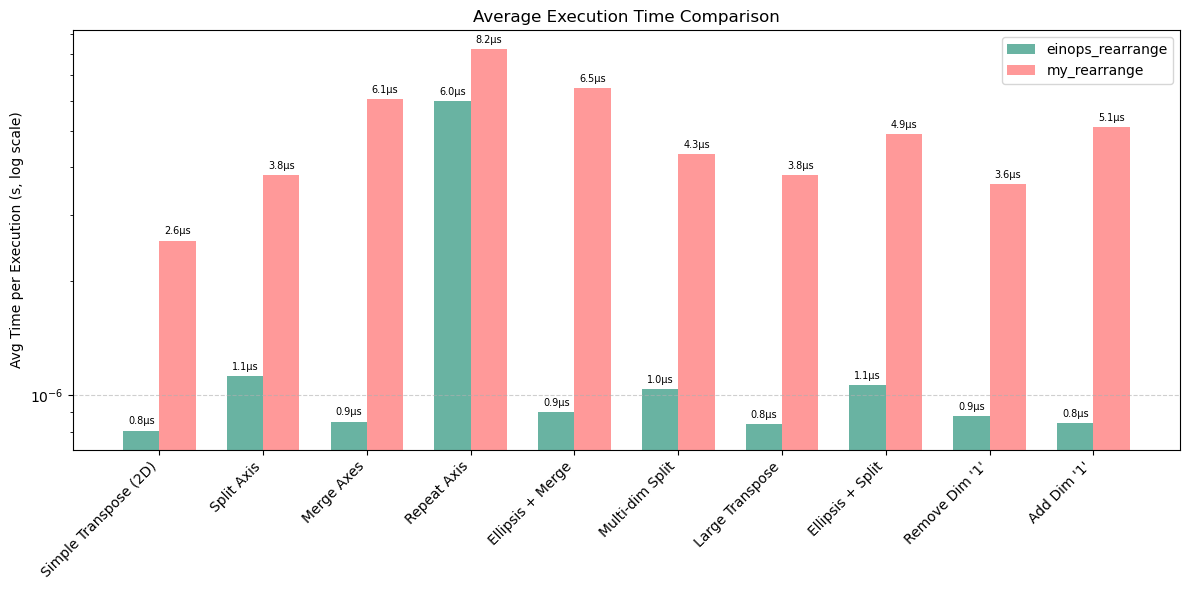

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange as einops_rearrange, repeat as einops_repeat
import timeit
import gc

def run_benchmark(description, setup_code, stmt1, stmt2, global_vars, number=1000, repeat=7):
    try:
        timer1 = timeit.Timer(stmt=stmt1, setup=setup_code, globals=global_vars)
        timer2 = timeit.Timer(stmt=stmt2, setup=setup_code, globals=global_vars)
        times1 = timer1.repeat(repeat=repeat, number=number)
        times2 = timer2.repeat(repeat=repeat, number=number)
        return {
            "description": description,
            "time1": np.mean(times1) / number,  # Changed from min to mean
            "time2": np.mean(times2) / number,  # Changed from min to mean
            "name1": stmt1.split('(')[0],
            "name2": stmt2.split('(')[0]
        }
    except Exception as e:
        print(f"Error in '{description}': {e}")
        return None

def plot_results(results):
    if not results:
        print("No results to plot.")
        return

    labels = [r["description"] for r in results]
    times1 = [r["time1"] for r in results]
    times2 = [r["time2"] for r in results]
    name1, name2 = results[0]["name1"], results[0]["name2"]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, times1, width, label=name1, color='#69b3a2')
    ax.bar(x + width/2, times2, width, label=name2, color='#ff9999')

    ax.set_ylabel('Avg Time per Execution (s, log scale)')
    ax.set_title('Average Execution Time Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.set_yscale('log')

    for bars in [ax.patches[:len(labels)], ax.patches[len(labels):]]:
        for bar in bars:
            height = bar.get_height()
            unit, factor = ('μs', 1e6) if height < 1e-3 else ('ms', 1e3) if height < 1 else ('s', 1)
            ax.annotate(f'{height * factor:.1f}{unit}',
                        (bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=7)

    plt.tight_layout()
    plt.show()

def get_benchmark_cases():
    cases = [
        ("Simple Transpose (2D)", (50, 60), 'h w -> w h', {}),
        ("Split Axis", (120, 10), '(h w) c -> h w c', {"h": 30}),
        ("Merge Axes", (10, 12, 5), 'a b c -> (a b) c', {}),
        ("Repeat Axis", (20, 1, 30), 'a 1 c -> a b c', {"b": 4}),
        ("Ellipsis + Merge", (5, 10, 4, 6), '... h w -> ... (h w)', {}),
        ("Multi-dim Split", (4, 60, 10), 'a (b c) d -> a b c d', {"b": 6}),
        ("Large Transpose", (16, 64, 64, 3), 'b h w c -> b c h w', {}),
        ("Ellipsis + Split", (2, 4, 64, 16), 'b c (h w) d -> b c h w d', {"h": 8}),
        ("Remove Dim '1'", (10, 1, 20), 'a 1 c -> a c', {}),
        ("Add Dim '1'", (10, 20), 'a c -> a 1 c', {})
    ]

    return [{
        "description": desc,
        "setup_code": f"tensor = np.random.rand(*{shape}); pattern = '{pattern}'; kw = {axes}",
        "stmt1": f"einops_rearrange(tensor, pattern, **kw)" if "Repeat" not in desc else f"einops_repeat(tensor, pattern, **kw)",
        "stmt2": f"my_rearrange(tensor, pattern, **kw)"
    } for desc, shape, pattern, axes in cases]

def main():
    global_vars = {"np": np, "einops_rearrange": einops_rearrange, "einops_repeat": einops_repeat, "my_rearrange": rearrange, "gc": gc}
    cases = get_benchmark_cases()
    results = [r for r in (run_benchmark(c["description"], c["setup_code"], c["stmt1"], c["stmt2"], global_vars, 100000, 7) for c in cases) if r]
    plot_results(results)

main()

# Testing offical einops demo

In [46]:
from PIL.Image import fromarray
from IPython import get_ipython


def display_np_arrays_as_images():
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype="uint8"))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype="uint8"))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print("<array of shape {}>".format(obj.shape))

    get_ipython().display_formatter.formatters["image/png"].for_type(np.ndarray, np_to_png)
    get_ipython().display_formatter.formatters["text/plain"].for_type(np.ndarray, np_to_text)

In [49]:
ims = np.load("./assets/test_images.npy", allow_pickle=False)
display_np_arrays_as_images()

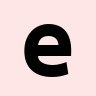

In [50]:
ims[0]

## Making sure we are using the custom version of rearrange

In [65]:
rearrange.__annotations__


{'tensor': numpy.ndarray,
 'pattern': str,
 'axes_lengths': int,
 'return': numpy.ndarray}

## Transpose

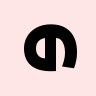

In [51]:
# rearrange, as the name suggests, rearranges elements
# below we swapped height and width.
# In other words, transposed first two axes (dimensions)
rearrange(ims[0], "h w c -> w h c")


## Composition of axes

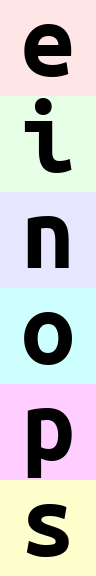

In [52]:
# einops allows seamlessly composing batch and height to a new height dimension
# We just rendered all images by collapsing to 3d tensor!
rearrange(ims, "b h w c -> (b h) w c")


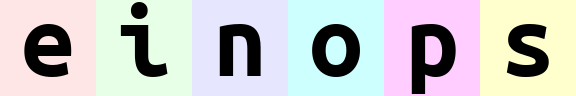

In [53]:
# or compose a new dimension of batch and width
rearrange(ims, "b h w c -> h (b w) c")


## Decomposition of axis


In [54]:
# decomposition is the inverse process - represent an axis as a combination of new axes
# several decompositions possible, so b1=2 is to decompose 6 to b1=2 and b2=3
rearrange(ims, "(b1 b2) h w c -> b1 b2 h w c ", b1=2).shape

(2, 3, 96, 96, 3)

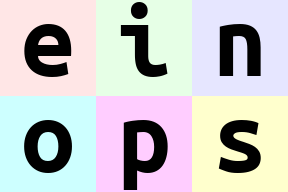

In [66]:
# finally, combine composition and decomposition:
rearrange(ims, "(b1 b2) h w c -> (b1 h) (b2 w) c ", b1=2)

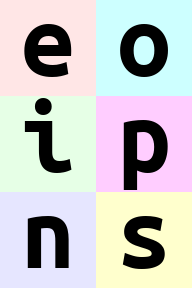

In [67]:
# slightly different composition: b1 is merged with width, b2 with height
# ... so letters are ordered by w then by h
rearrange(ims, "(b1 b2) h w c -> (b2 h) (b1 w) c ", b1=2)

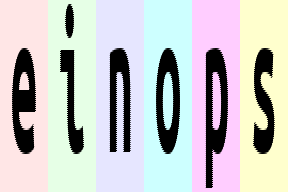

In [68]:
# move part of width dimension to height.
# we should call this width-to-height as image width shrunk by 2 and height doubled.
# but all pixels are the same!
# Can you write reverse operation (height-to-width)?
rearrange(ims, "b h (w w2) c -> (h w2) (b w) c", w2=2)

## Order of axes matters


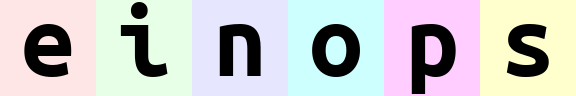

In [69]:
# compare with the next example
rearrange(ims, "b h w c -> h (b w) c")


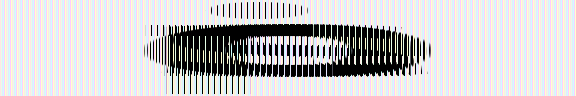

In [70]:
# order of axes in composition is different
# rule is just as for digits in the number: leftmost digit is the most significant,
# while neighboring numbers differ in the rightmost axis.
# you can also think of this as lexicographic sort
rearrange(ims, "b h w c -> h (w b) c")

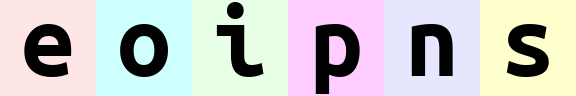

In [71]:
# what if b1 and b2 are reordered before composing to width?
rearrange(ims, "(b1 b2) h w c -> h (b1 b2 w) c ", b1=2)  # produces 'einops'
rearrange(ims, "(b1 b2) h w c -> h (b2 b1 w) c ", b1=2)  # produces 'eoipns'

## Addition or removal of axes

In [72]:
x = rearrange(ims, "b h w c -> b 1 h w 1 c")  # functionality of numpy.expand_dims
print(x.shape)
print(rearrange(x, "b 1 h w 1 c -> b h w c").shape)  # functionality of numpy.squeeze

(6, 1, 96, 96, 1, 3)
(6, 96, 96, 3)


## Weird stuff

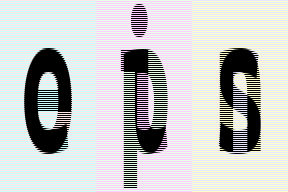

In [80]:

# interweaving along vertical for couples of images
rearrange(ims, "(b1 b2) h w c -> (h b1) (b2 w) c", b1=2)

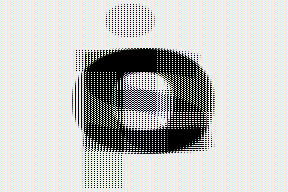

In [81]:
# interweaving pixels of different pictures
# all letters are observable
rearrange(ims, "(b1 b2) h w c -> (h b1) (w b2) c ", b1=2)

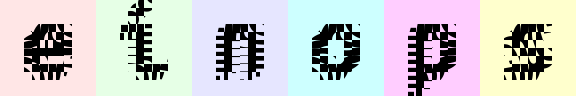

In [82]:

# split in small patches and transpose each patch
rearrange(ims, "b (h1 h2) (w1 w2) c -> (h1 w2) (b w1 h2) c", h2=8, w2=8)

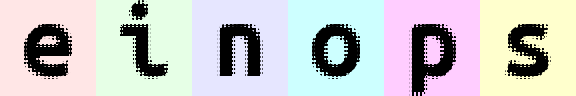

In [83]:
# stop me someone!
rearrange(ims, "b (h1 h2 h3) (w1 w2 w3) c -> (h1 w2 h3) (b w1 h2 w3) c", h2=2, w2=2, w3=2, h3=2)

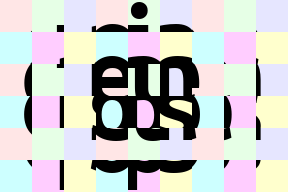

In [84]:
rearrange(ims, "(b1 b2) (h1 h2) (w1 w2) c -> (h1 b1 h2) (w1 b2 w2) c", h1=3, w1=3, b2=3)